# Predict & Evaluate

In [1]:
import os
from glob import glob
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt

%load_ext tensorboard
%matplotlib inline

## Hyperparameter Tunning

In [2]:
num_epochs = 20
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [3]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [4]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='sparse_categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

# Data Preprocess

In [5]:
train_paths = glob('../dataset/cifar/train/*.png')[:1000]
test_paths = glob('../dataset/cifar/test/*.png')[:1000]

In [6]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

In [7]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [8]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot)  # 이번에는 onehot이 아닌 label 번호로

In [9]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.  # rescale
    
    label = get_label(path)
    return image, label

In [10]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [13]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

## Training

In [14]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs
)

Epoch 1/20
31/31 [==============================] - 8s 243ms/step - loss: 2.3237 - accuracy: 0.1054 - val_loss: 2.3006 - val_accuracy: 0.1401
Epoch 2/20
31/31 [==============================] - 7s 226ms/step - loss: 2.2857 - accuracy: 0.1312 - val_loss: 2.2914 - val_accuracy: 0.1401
Epoch 3/20
31/31 [==============================] - 7s 234ms/step - loss: 2.2771 - accuracy: 0.1230 - val_loss: 2.2395 - val_accuracy: 0.1583
Epoch 4/20
31/31 [==============================] - 7s 216ms/step - loss: 2.2354 - accuracy: 0.1631 - val_loss: 2.2251 - val_accuracy: 0.1431
Epoch 5/20
31/31 [==============================] - 7s 215ms/step - loss: 2.1731 - accuracy: 0.1890 - val_loss: 2.0923 - val_accuracy: 0.2087
Epoch 6/20
31/31 [==============================] - 7s 218ms/step - loss: 2.1595 - accuracy: 0.1829 - val_loss: 2.0610 - val_accuracy: 0.2702
Epoch 7/20
31/31 [==============================] - 7s 216ms/step - loss: 2.0411 - accuracy: 0.2572 - val_loss: 2.0432 - val_accuracy: 0.2369
Epoch 

# Predict

### 이미지를 Load 직접 load해서 넣는 방법

In [15]:
path = train_paths[0]
test_image, test_label = load_image_label(path)

In [16]:
test_image.shape

TensorShape([32, 32, 3])

In [17]:
test_image = test_image[tf.newaxis, ...]
test_image.shape

TensorShape([1, 32, 32, 3])

In [18]:
pred = model.predict(test_image)

In [19]:
pred

array([[0.00186033, 0.00111492, 0.08962503, 0.10541584, 0.1498315 ,
        0.13173772, 0.4373092 , 0.08186253, 0.00072246, 0.00052034]],
      dtype=float32)

In [20]:
np.argmax(pred)

6

### generator에서 데이터를 가져오는 방법

In [21]:
test_image, test_label = next(iter(test_dataset))

In [22]:
test_image.shape

TensorShape([32, 32, 32, 3])

In [23]:
pred = model.predict(test_image)
pred.shape

(32, 10)

In [24]:
pred[0]

array([0.00986753, 0.00304143, 0.08633912, 0.27564576, 0.1151012 ,
       0.20519562, 0.08399658, 0.20291476, 0.00921955, 0.00867846],
      dtype=float32)

In [25]:
np.argmax(pred[0])

3

## Predict

In [26]:
pred = model.predict(test_dataset.take(1))

In [27]:
pred.shape

(32, 10)

In [28]:
pred = model.predict(test_dataset.take(2))
pred.shape

(64, 10)

## Evaluate

In [29]:
image, label = next(iter(test_dataset))
evals =  model.evaluate(image, label)

1/1 [==============================] - 0s 996us/step - loss: 1.7172 - accuracy: 0.5000


## Confirm

In [30]:
image.shape

TensorShape([32, 32, 32, 3])

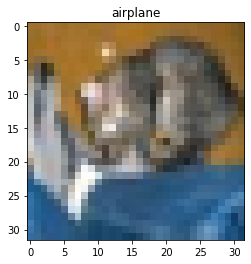

In [31]:
plt.imshow(image[0])
plt.title(class_names[np.argmax(label[0])])
plt.show()

In [32]:
class_names

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')